# Installation for Colab

In [2]:
!pip3 install gensim

In [ ]:
!pip3 install pyLDAvis

In [ ]:
!pip uninstall -y numpy
!pip uninstall -y setuptools
!pip install setuptools
!pip install numpy

In [5]:
!pip3 install nltk

In [1]:
import time
import re
import numpy as np
import pandas as  pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel


import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from string import punctuation

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 1) Load Dataset

In [2]:
import json
from pathlib import Path
from pandas import json_normalize
# # https://data.world/crawlfeeds/bloomberg-quint-news-dataset
path_json = Path(r'bloomberg_quint_news.json')

# read the file in and load using the json module
with path_json.open('r', encoding='utf-8') as f:
    data = json.loads(f.read())

# create a dataframe
df = json_normalize(data)
print(df.shape)
print(df.category.unique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(7018, 11)
['Markets' 'Business' 'Research Reports' 'Businessweek' 'OnWeb'
 'Opinion/Gadfly' 'Mutual Funds' 'BQ Blue Exclusive' 'Videos/In The News'
 'Global Economics' 'GST' 'Pursuits' 'Videos/Hot Money' 'Opinion'
 'Politics' 'Law-and-Policy' 'China' 'Opinion/View' 'Technology'
 'Coronavirus Outbreak' 'Charts' 'QuickTakes' 'Wealth' 'Lifestyle'
 'Markets/Quarterly Earnings' 'Videos/The Mutual Fund Show'
 'Economy & Finance' 'BQ Brand Studio' 'Crypto' 'IPOs' 'CityLab' 'Videos']


In [3]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,url,title,short_description,author,date_created,date_modified,category,raw_description,description,publisher,scraped_at
0,https://www.bloombergquint.com/markets/all-you...,All You Need To Know Going Into Trade On Septe...,"Stocks in the news, big brokerage calls of the...",Darshan A Nakhwa,"23 Sep 2021, 7:05 AM IST","23 Sep 2021, 7:05 AM IST",Markets,"<div class=""story-element story-element-text"">...",Asian stocks were steady early Thursday after ...,https://www.bloombergquint.com/,2021-09-24 00:01:25
1,https://www.bloombergquint.com/business/bridge...,"Bridgestone CEO Backs Safe Tokyo Olympics, Dia...","Bridgestone CEO Backs Safe Tokyo Olympics, Dia...",Shiho Takezawa &,"23 Apr 2021, 5:35 AM IST","23 Apr 2021, 6:35 AM IST",Business,"<div class=""story-element story-element-text"">...",Bridgestone Corp. will support the Tokyo Olym...,https://www.bloombergquint.com/,2021-09-24 00:01:26
2,https://www.bloombergquint.com/markets/stocks-...,"Stocks To Watch: HCL Tech, Cyient, M&M Financi...",Here are the stocks to watch in trade today...,BQ Desk,"23 Apr 2021, 7:29 AM IST","23 Apr 2021, 7:29 AM IST",Markets,"<div class=""story-element story-element-text"">...",Indian equity benchmarks reversed losses made ...,https://www.bloombergquint.com/,2021-09-24 00:01:26
3,https://www.bloombergquint.com/research-report...,Localised Lockdowns Cannot But Impinge On Econ...,Localised Lockdowns Cannot But Impinge On Econ...,Nirmal Bang Institutional Research,"26 Apr 2021, 7:58 AM IST","26 Apr 2021, 7:58 AM IST",Research Reports,"<div class=""story-element story-element-text"">...","Nirmal Bang Report, We assess the ‘state of af...",https://www.bloombergquint.com/,2021-09-24 00:01:26
4,https://www.bloombergquint.com/business/cp-rai...,CP Rail Wins Regulator Exemption From Tougher ...,CP Rail Wins Regulator Exemption From Tougher ...,Thomas Black,"24 Apr 2021, 7:08 AM IST","24 Apr 2021, 7:44 AM IST",Business,"<div class=""story-element story-element-text"">...",Canadian Pacific Railway Ltd. won a petition ...,https://www.bloombergquint.com/,2021-09-24 00:01:27


In [4]:
df = df.drop(['url','short_description','author',"date_created",	"date_modified",	"category",	"raw_description","publisher",	"scraped_at"	], axis=1)
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,description
0,All You Need To Know Going Into Trade On Septe...,Asian stocks were steady early Thursday after ...
1,"Bridgestone CEO Backs Safe Tokyo Olympics, Dia...",Bridgestone Corp. will support the Tokyo Olym...
2,"Stocks To Watch: HCL Tech, Cyient, M&M Financi...",Indian equity benchmarks reversed losses made ...
3,Localised Lockdowns Cannot But Impinge On Econ...,"Nirmal Bang Report, We assess the ‘state of af..."
4,CP Rail Wins Regulator Exemption From Tougher ...,Canadian Pacific Railway Ltd. won a petition ...


In [5]:
df.description[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"Asian stocks were steady early Thursday after U.S. shares took in their stride the prospect of a reduction in Federal Reserve stimulus, as early as November. The Treasury yield curve flattened., Stocks rose in Australia and dipped in South Korea. Japan is shut for a holiday and Hong Kong will reopen from one. U.S. futures climbed after the S&P 500 pushed higher for the first time in five sessions and the Nasdaq 100 advanced., Fed Chair Jerome Powell said the central bank could begin scaling back asset purchases in November and complete the process by mid-2022. Officials also revealed a growing inclination to raise interest rates next year. Shorter-maturity Treasury notes fell while longer-maturity debt edged higher. The dollar rose. Cash Treasuries won’t trade in Asia because of the Japan holiday., The Singapore-traded SGX Nifty, an early indicator of India's Nifty 50 Index’s performance, rose 0.56% to 17,649.00, as of 7:00 a.m., Traders are continuing to monitor the debt crisis at Ch

In [6]:
df = df[df["description"]!=""]
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4106, 2)

# 2) Preprocessing

In [8]:
text_data = df.description.tolist()
print("description len:",len(text_data))
print()
print(text_data[0])

description len: 4106

Asian stocks were steady early Thursday after U.S. shares took in their stride the prospect of a reduction in Federal Reserve stimulus, as early as November. The Treasury yield curve flattened., Stocks rose in Australia and dipped in South Korea. Japan is shut for a holiday and Hong Kong will reopen from one. U.S. futures climbed after the S&P 500 pushed higher for the first time in five sessions and the Nasdaq 100 advanced., Fed Chair Jerome Powell said the central bank could begin scaling back asset purchases in November and complete the process by mid-2022. Officials also revealed a growing inclination to raise interest rates next year. Shorter-maturity Treasury notes fell while longer-maturity debt edged higher. The dollar rose. Cash Treasuries won’t trade in Asia because of the Japan holiday., The Singapore-traded SGX Nifty, an early indicator of India's Nifty 50 Index’s performance, rose 0.56% to 17,649.00, as of 7:00 a.m., Traders are continuing to monitor

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
text_data_processed = []

T_START_preprocess1 = time.time()
for sentence in text_data:
  sent_new = re.sub(r'\S*@\S*\s?', '', sentence)
  sent_new = re.sub(r"\d+", "", sent_new)
  sent_new = re.sub(r"\[[^()]*\]","", sent_new)
  sent_new = re.sub(r'\s+', ' ', sent_new)
  sent_new = re.sub(r"\'", "", sent_new)
  text_data_processed.append(sent_new)
T_END_preprocess1 = time.time()

print(len(text_data_processed))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4106


In [10]:
print(text_data_processed[0])

Asian stocks were steady early Thursday after U.S. shares took in their stride the prospect of a reduction in Federal Reserve stimulus, as early as November. The Treasury yield curve flattened., Stocks rose in Australia and dipped in South Korea. Japan is shut for a holiday and Hong Kong will reopen from one. U.S. futures climbed after the S&P pushed higher for the first time in five sessions and the Nasdaq advanced., Fed Chair Jerome Powell said the central bank could begin scaling back asset purchases in November and complete the process by mid-. Officials also revealed a growing inclination to raise interest rates next year. Shorter-maturity Treasury notes fell while longer-maturity debt edged higher. The dollar rose. Cash Treasuries won’t trade in Asia because of the Japan holiday., The Singapore-traded SGX Nifty, an early indicator of Indias Nifty Index’s performance, rose .% to ,., as of : a.m., Traders are continuing to monitor the debt crisis at China Evergrande Group. Some inv

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
stop_words = set(stopwords.words('english'))
punctuations_list = list(punctuation)
wnet_lemma = WordNetLemmatizer()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Preprocessing v2 (WNet Lemmatization)

In [12]:
def lemmatize_doc(doc, active_bigram=False):
  # print("ORIGINAL:")
  # print(doc)

  # # split to words and get non stop words
  words_stop_free = " ".join([w for w in doc.lower().split() if w not in stop_words])
  # print("TYPE wstopfree:",type(words_stop_free))
  # print(words_stop_free)

  # # get punction free words
  punc_free = ''.join(ch for ch in words_stop_free if ch not in punctuations_list)
  # print("TYPE punc_free:",type(punc_free))
  # print(punc_free)

  if active_bigram == True:
    # # get bigrams
    bigram = [' '.join(w) for w in ngrams(punc_free.split(" "), 2)]
    # print("TYPE bigram:",type(bigram))
    # print(bigram)

    # # lemmatize
    lemmatized = " ".join(wnet_lemma.lemmatize(w) for w in bigram)
    return lemmatized

  # # lemmatize
  lemmatized = " ".join(wnet_lemma.lemmatize(w) for w in punc_free.split())
  # print("TYPE lemmatized:",type(lemmatized))
  # print(lemmatized)

  return lemmatized

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
T_START_process2_lemmatization = time.time()
text_lemmatized = []
for text in text_data_processed:
  text_lemmatized.append(lemmatize_doc(text, active_bigram=False).split())
T_END_process2_lemmatization = time.time()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
text_lemmatized[:1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['asian',
  'stock',
  'steady',
  'early',
  'thursday',
  'u',
  'share',
  'took',
  'stride',
  'prospect',
  'reduction',
  'federal',
  'reserve',
  'stimulus',
  'early',
  'november',
  'treasury',
  'yield',
  'curve',
  'flattened',
  'stock',
  'rose',
  'australia',
  'dipped',
  'south',
  'korea',
  'japan',
  'shut',
  'holiday',
  'hong',
  'kong',
  'reopen',
  'one',
  'u',
  'future',
  'climbed',
  'sp',
  'pushed',
  'higher',
  'first',
  'time',
  'five',
  'session',
  'nasdaq',
  'advanced',
  'fed',
  'chair',
  'jerome',
  'powell',
  'said',
  'central',
  'bank',
  'could',
  'begin',
  'scaling',
  'back',
  'asset',
  'purchase',
  'november',
  'complete',
  'process',
  'mid',
  'official',
  'also',
  'revealed',
  'growing',
  'inclination',
  'raise',
  'interest',
  'rate',
  'next',
  'year',
  'shortermaturity',
  'treasury',
  'note',
  'fell',
  'longermaturity',
  'debt',
  'edged',
  'higher',
  'dollar',
  'rose',
  'cash',
  'treasury',
  '

# 3) Create Dictionary(id&word) and DTM

In [ ]:
# # # LIMIT DOCUMENTS
# # print(len(text_lemmatized))
# # text_lemmatized = text_lemmatized[:100]
# # print(len(text_lemmatized))

In [15]:
T_START_create_dict = time.time()
dictionary_idword = corpora.Dictionary(text_lemmatized)
# filter words that occurs in less than 1 query and more than 90%
dictionary_idword.filter_extremes(no_below=1, no_above=0.9)
T_END_create_dict = time.time()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
T_START_create_DTM = time.time()
doc_term_matrix = [dictionary_idword.doc2bow(text) for text in text_lemmatized]
T_END_create_DTM = time.time()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
print(doc_term_matrix[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 6), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 4), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 11), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 7), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 4), (81, 1), (82, 1), (83, 2), (84, 1), (85, 10), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 2), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 3), (103, 1), (104, 3), (105, 1), (106, 1), (107, 1), (108, 1), (109, 4), (110, 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
print(doc_term_matrix[4:5])

[[(3, 2), (12, 1), (21, 1), (32, 1), (38, 2), (41, 4), (62, 1), (68, 1), (72, 1), (88, 1), (125, 2), (143, 1), (196, 3), (211, 1), (228, 1), (237, 1), (271, 1), (281, 1), (295, 4), (305, 2), (347, 2), (358, 1), (386, 1), (392, 6), (411, 1), (435, 1), (436, 1), (458, 3), (482, 1), (549, 1), (550, 1), (551, 1), (552, 2), (553, 2), (554, 1), (555, 1), (556, 1), (557, 2), (558, 1), (559, 1), (560, 1), (561, 2), (562, 2), (563, 1), (564, 1), (565, 3), (566, 1), (567, 1), (568, 1), (569, 1), (570, 1), (571, 1), (572, 1), (573, 1), (574, 1), (575, 1), (576, 1), (577, 1), (578, 1), (579, 1), (580, 1), (581, 1), (582, 1), (583, 1), (584, 1), (585, 1), (586, 1), (587, 1), (588, 6), (589, 1), (590, 3), (591, 1), (592, 1), (593, 1), (594, 1), (595, 1), (596, 1), (597, 1), (598, 1), (599, 1), (600, 1), (601, 1), (602, 1), (603, 1), (604, 1), (605, 1), (606, 2), (607, 1), (608, 1), (609, 1), (610, 5), (611, 2), (612, 1), (613, 1), (614, 1), (615, 1), (616, 2), (617, 1), (618, 1), (619, 2), (620, 1),

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
print(dictionary_idword[7])

advanced


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 4) LDA Model

In [ ]:
LDA = gensim.models.LdaModel

## 4.1) Parameter Search

In [24]:
NUM_TOPICS = [8,12]
CHUNK_SIZES = [50,200]
NUM_PASSES = [50,150]
PARAMS_ALPHA = ["symmetric", "auto"]

eval_scores = []

for PARAM_ALPHA in PARAMS_ALPHA:
  for NUM_TOPIC in NUM_TOPICS:
    for CHUNK_SIZE in CHUNK_SIZES:
      for NUM_PASS in NUM_PASSES:
        print(f"{NUM_TOPIC}, {CHUNK_SIZE}, {NUM_PASS}, {PARAM_ALPHA}".format(
            NUM_TOPIC, CHUNK_SIZE, NUM_PASS, PARAM_ALPHA))

        T_START_LDA_training = time.time()
        lda_model = LDA(corpus = doc_term_matrix,
                        id2word = dictionary_idword,

                        num_topics = NUM_TOPIC,
                        passes = NUM_PASS,      # no of passes through the corpus during training
                        chunksize = CHUNK_SIZE, # no of doc's to be used in each training
                        alpha = PARAM_ALPHA,

                        per_word_topics = True,
                        random_state = 42
                        )

        T_END_LDA_training = time.time()

        perplexity_lda = lda_model.log_perplexity(doc_term_matrix)

        coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=text_lemmatized,
                                     dictionary=dictionary_idword,
                                     coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()

        lda_time = T_END_LDA_training - T_START_LDA_training
        eval_scores.append({
            'Number of Topics': NUM_TOPIC,
            'Chunk Size': CHUNK_SIZE,
            'Number of Passes': NUM_PASS,
            'Alpha':PARAM_ALPHA,
            'Time':lda_time,
            'Perplexity': perplexity_lda,
            'Coherence Score': coherence_lda
        })


eval_scores_df = pd.DataFrame(eval_scores,columns=['Number of Topics','Chunk Size','Number of Passes','Alpha','Time','Perplexity','Coherence Score'])
eval_scores_df.to_csv('LDA_parameter_eval.csv')

eval_scores_df_sorted = eval_scores_df.sort_values("Coherence Score", ascending=False)
eval_scores_df_sorted.to_csv('LDA_parameter_eval_coh_sorted.csv')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


8, 50, 50, symmetric
8, 50, 150, symmetric
8, 200, 50, symmetric
8, 200, 150, symmetric
12, 50, 50, symmetric
12, 50, 150, symmetric
12, 200, 50, symmetric
12, 200, 150, symmetric
8, 50, 50, auto
8, 50, 150, auto
8, 200, 50, auto
8, 200, 150, auto
12, 50, 50, auto
12, 50, 150, auto
12, 200, 50, auto
12, 200, 150, auto


In [25]:
eval_scores_df_sorted

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Number of Topics,Chunk Size,Number of Passes,Alpha,Time,Perplexity,Coherence Score
14,12,200,50,auto,326.369143,-9.892712,0.504308
6,12,200,50,symmetric,327.599073,-9.898916,0.499482
15,12,200,150,auto,975.202952,-9.875065,0.498671
7,12,200,150,symmetric,987.427674,-9.880902,0.494090
5,12,50,150,symmetric,1841.266960,-10.604213,0.470954
4,12,50,50,symmetric,605.327916,-10.622522,0.466916
11,8,200,150,auto,775.118574,-8.692114,0.465276
13,12,50,150,auto,1785.816419,-10.589635,0.462043
2,8,200,50,symmetric,265.115952,-8.754468,0.460507
10,8,200,50,auto,262.155938,-8.750417,0.457758


## 4.2) Single Model

In [26]:
BEST_NUM_TOPICS = eval_scores_df_sorted.iloc[0]["Number of Topics"]
BEST_NUM_PASSES = eval_scores_df_sorted.iloc[0]["Number of Passes"]
BEST_CHUNK_SIZE = eval_scores_df_sorted.iloc[0]["Chunk Size"]
print("BEST_NUM_TOPICS:", BEST_NUM_TOPICS)
print("BEST_NUM_PASSES:", BEST_NUM_PASSES)
print("BEST_CHUNK_SIZE:", BEST_CHUNK_SIZE)

T_START_LDA_training = time.time()
LDA = gensim.models.LdaModel
lda_model = LDA(corpus = doc_term_matrix,
                id2word = dictionary_idword,

                num_topics= BEST_NUM_TOPICS,
                passes= BEST_NUM_PASSES,      # no of passes through the corpus during training
                chunksize = BEST_CHUNK_SIZE,   # no of doc's to be used in each training

                per_word_topics=True,
                alpha='auto',
                random_state=42
                )

T_END_LDA_training = time.time()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


BEST_NUM_TOPICS: 12
BEST_NUM_PASSES: 50
BEST_CHUNK_SIZE: 200


In [28]:
pprint(lda_model.print_topics())


[(0,
  '0.018*"said" + 0.017*"year" + 0.008*"bloomberg" + 0.008*"price" + '
  '0.008*"month" + 0.007*"market" + 0.007*"last" + 0.006*"u" + '
  '0.006*"pandemic" + 0.006*"economy"'),
 (1,
  '0.026*"company" + 0.022*"said" + 0.013*"billion" + 0.011*"year" + '
  '0.010*"million" + 0.009*"bloomberg" + 0.009*"inc" + 0.008*"business" + '
  '0.008*"according" + 0.008*"share"'),
 (2,
  '0.032*"water" + 0.029*"food" + 0.028*"crop" + 0.016*"corn" + '
  '0.015*"irrigation" + 0.014*"farm" + 0.012*"warming" + 0.012*"agriculture" + '
  '0.011*"wheat" + 0.011*"brazil"'),
 (3,
  '0.022*"minister" + 0.019*"government" + 0.018*"european" + 0.015*"country" '
  '+ 0.015*"uk" + 0.013*"prime" + 0.011*"climate" + 0.010*"eu" + 0.010*"party" '
  '+ 0.009*"military"'),
 (4,
  '0.021*"said" + 0.010*"tax" + 0.010*"president" + 0.010*"u" + 0.009*"would" '
  '+ 0.009*"biden" + 0.008*"state" + 0.007*"court" + 0.007*"law" + '
  '0.006*"house"'),
 (5,
  '0.070*"bank" + 0.025*"bond" + 0.021*"debt" + 0.021*"asset" + '
 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
pprint(lda_model.print_topics(num_words=4))


[(0, '0.018*"said" + 0.017*"year" + 0.008*"bloomberg" + 0.008*"price"'),
 (1, '0.026*"company" + 0.022*"said" + 0.013*"billion" + 0.011*"year"'),
 (2, '0.032*"water" + 0.029*"food" + 0.028*"crop" + 0.016*"corn"'),
 (3,
  '0.022*"minister" + 0.019*"government" + 0.018*"european" + 0.015*"country"'),
 (4, '0.021*"said" + 0.010*"tax" + 0.010*"president" + 0.010*"u"'),
 (5, '0.070*"bank" + 0.025*"bond" + 0.021*"debt" + 0.021*"asset"'),
 (6, '0.064*"china" + 0.033*"chinese" + 0.023*"china’s" + 0.022*"hong"'),
 (7, '0.027*"russian" + 0.025*"russia" + 0.017*"putin" + 0.010*"hindu"'),
 (8, '0.026*"vaccine" + 0.021*"said" + 0.018*"covid" + 0.018*"india"'),
 (9, '0.032*"energy" + 0.026*"gas" + 0.024*"oil" + 0.024*"power"'),
 (10, '0.010*"one" + 0.010*"it’s" + 0.009*"say" + 0.009*"like"'),
 (11, '0.029*"r" + 0.020*"crore" + 0.015*"fy" + 0.015*"growth"')]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
doc_lda = lda_model[doc_term_matrix]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 5) Evaluation

In [32]:
T_START_perplexity = time.time()
perplexity_lda = lda_model.log_perplexity(doc_term_matrix)
T_END_perplexity = time.time()
print('Perplexity: ', perplexity_lda)

T_START_coherence = time.time()
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=text_lemmatized,
                                     dictionary=dictionary_idword,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
T_END_coherence = time.time()
print('Coherence Score: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  -9.892711734883502
Coherence Score:  0.5043082291878379


In [33]:
t_preprocess = T_END_preprocess1 - T_START_preprocess1
t_lemma = T_END_process2_lemmatization - T_START_process2_lemmatization
t_create_dict = T_END_create_dict - T_START_create_dict
t_create_dtm = T_END_create_DTM - T_START_create_DTM
t_training_lda = T_END_LDA_training - T_START_LDA_training

t_total = t_preprocess + t_lemma + t_create_dict + t_create_dtm + t_training_lda

print("Time Preprocessing:",t_preprocess)
print("Time Process2+Lemmatization:",t_lemma)
print("Time Create Dictionary:",t_create_dict)
print("Time Create DTM:",t_create_dtm)
print("Time Training LDA:",t_training_lda)
print("Total Processing Time:",t_total)

Time Preprocessing: 4.388025522232056
Time Process2+Lemmatization: 20.910825729370117
Time Create Dictionary: 1.7079429626464844
Time Create DTM: 1.57944917678833
Time Training LDA: 332.37446093559265
Total Processing Time: 360.96070432662964


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 6) Visualization

In [34]:
T_START_vis = time.time()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model,
                              doc_term_matrix,
                              dictionary_idword)
T_START_vis = time.time()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.222386  0.067271       1        1  26.858125
1     -0.216994  0.081161       2        1  19.423336
10    -0.204310 -0.021285       3        1  16.444467
4     -0.205771 -0.127782       4        1  13.796348
8     -0.163007 -0.100758       5        1   7.666363
5      0.031770  0.224855       6        1   4.041270
3     -0.000074 -0.211500       7        1   3.882881
11     0.048934  0.249889       8        1   3.239092
9      0.177347 -0.064816       9        1   2.192684
6      0.205195 -0.061442      10        1   1.677551
7      0.274851 -0.027976      11        1   0.519856
2      0.274445 -0.007618      12        1   0.258028, topic_info=              Term          Freq         Total Category  logprob  loglift
34            bank   3397.000000   3397.000000  Default  30.0000  30.0000
66         company   6245.000000   6245.000000  Default  29.0000  29.0000
295           said  16206.000000  16206.000000  Default  28.0000  28.0000
899        vaccine   2346.000000   2346.000000  Default  27.0000  27.0000
58           china   1449.000000   1449.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
129           food     86.019001    471.856554  Topic12  -3.5548   4.2578
2956  agricultural     21.250164     58.009904  Topic12  -4.9530   4.9556
4686        brazil     32.414620    214.173408  Topic12  -4.5308   4.0717
4933       weather     23.147454    139.597745  Topic12  -4.8675   4.1630
8092           dry     10.618807     40.067349  Topic12  -5.6468   4.6319

[735 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
6652      9  0.993025        abu
3875      7  0.991289     accord
640       1  0.369792  according
640       2  0.435480  according
640       4  0.071359  according
...     ...       ...        ...
483       3  0.999547          —
638       1  0.640587       “the
638       2  0.095044       “the
638       4  0.245027       “the
638       7  0.019229       “the

[1343 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 11, 5, 9, 6, 4, 12, 10, 7, 8, 3])

In [36]:
eval_df_alpha_auto = eval_scores_df[eval_scores_df['Alpha']=="auto"]
eval_df_alpha_sym = eval_scores_df[eval_scores_df['Alpha']=="symmetric"]
eval_df_alpha_auto

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Number of Topics,Chunk Size,Number of Passes,Alpha,Time,Perplexity,Coherence Score
8,8,50,50,auto,430.904434,-8.968127,0.436378
9,8,50,150,auto,1294.230243,-8.909549,0.446728
10,8,200,50,auto,262.155938,-8.750417,0.457758
11,8,200,150,auto,775.118574,-8.692114,0.465276
12,12,50,50,auto,602.977599,-10.607046,0.455874
13,12,50,150,auto,1785.816419,-10.589635,0.462043
14,12,200,50,auto,326.369143,-9.892712,0.504308
15,12,200,150,auto,975.202952,-9.875065,0.498671


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


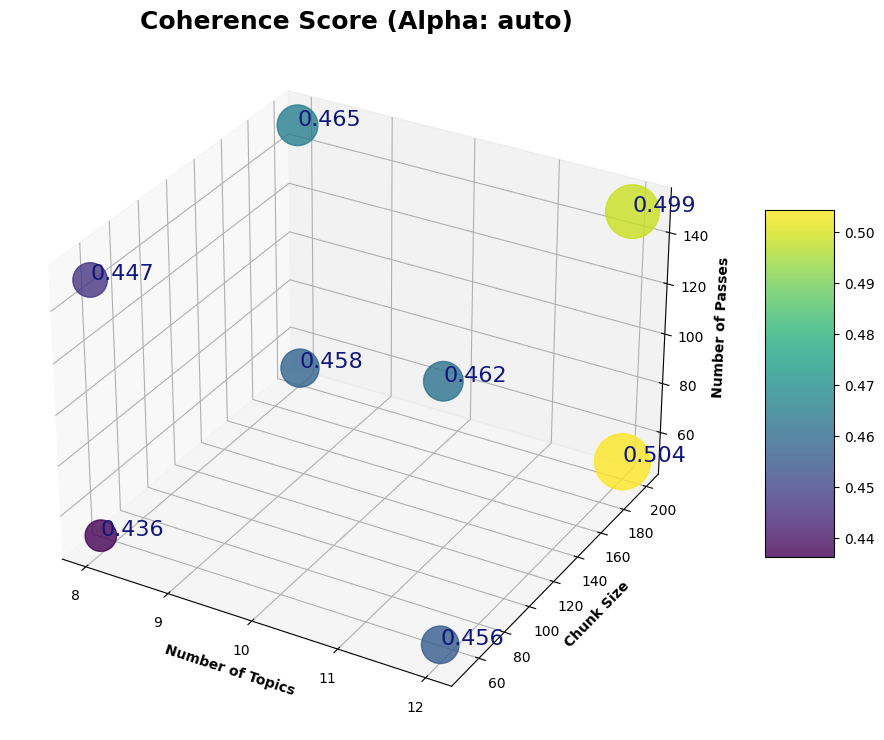

In [106]:
from mpl_toolkits import mplot3d

x = eval_df_alpha_auto["Number of Topics"]
y = eval_df_alpha_auto["Chunk Size"]
z = eval_df_alpha_auto["Number of Passes"]
c_score = eval_df_alpha_auto["Coherence Score"]
coh_sqr = eval_df_alpha_auto["Coherence Score"].apply(lambda x:(5*x)**8)

fig = plt.figure(figsize=(16,9))

ax = fig.add_subplot(projection='3d')
my_cmap = plt.get_cmap('viridis')

sctt = ax.scatter3D(x, y, z,
                    s=coh_sqr,
                    alpha = 0.8,
                    c = c_score,
                    cmap = my_cmap)
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)



for i in range(len(eval_df_alpha_auto)):
  x = eval_df_alpha_auto.iloc[i]["Number of Topics"]
  y = eval_df_alpha_auto.iloc[i]["Chunk Size"]
  z = eval_df_alpha_auto.iloc[i]["Number of Passes"]

  coh_score = round(eval_df_alpha_auto.iloc[i]["Coherence Score"],3)

  ax.text(x, y, z,
          '%s' % (str(coh_score)),
          size=16,
          zorder=5000,
          color='#0f167d')

ax.set_xticks([8,9,10,11,12])

plt.title("Coherence Score (Alpha: auto)", fontweight ='bold',size=18)

ax.set_xlabel('Number of Topics', fontweight ='bold')
ax.set_ylabel('Chunk Size', fontweight ='bold')
ax.set_zlabel('Number of Passes', fontweight ='bold')


plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


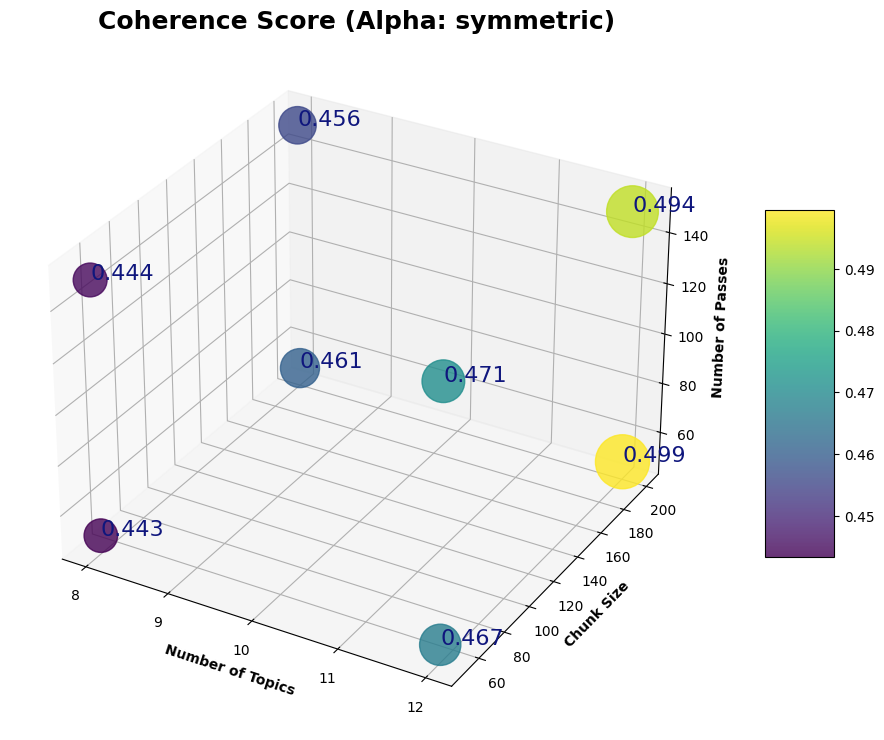

In [111]:
from utils_plot import get_3d_scatter_cmap

get_3d_scatter_cmap("symmetric",eval_df_alpha_sym)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


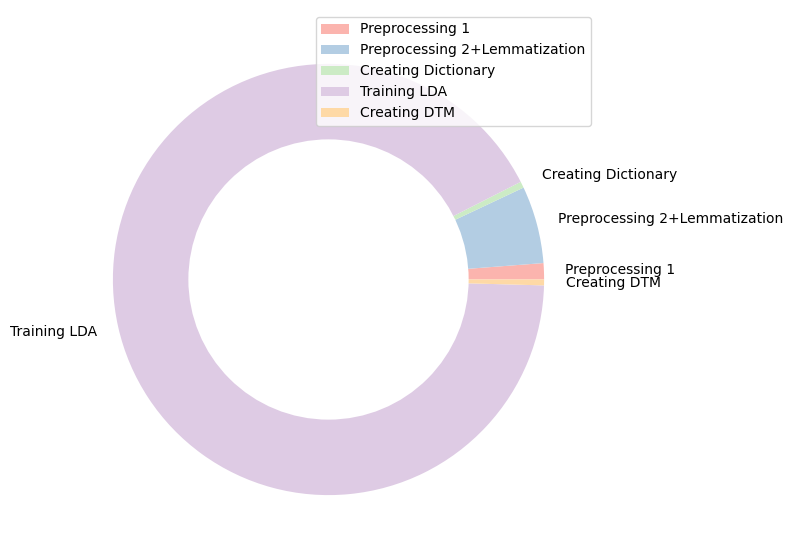

In [153]:
labels_t = ["Preprocessing 1",
          "Preprocessing 2+Lemmatization",
          "Creating Dictionary",
          "Training LDA",
          "Creating DTM"
          ]


data = [t_preprocess, t_lemma, t_create_dict, t_training_lda, t_create_dtm,]


fig = plt.figure(figsize =(10, 7))
plt.pie(data,
        labels = labels_t,
        colors=plt.cm.Pastel1.colors)

hole = plt.Circle((0, 0), 0.65, facecolor='white')

ax.set_title("Elapsed Time Spent on LDA Training")
plt.legend()

# show plot
plt.gcf().gca().add_artist(hole)
plt.show()

In [115]:
print(eval_scores_df_sorted.to_markdown())

|    |   Number of Topics |   Chunk Size |   Number of Passes | Alpha     |     Time |   Perplexity |   Coherence Score |
|---:|-------------------:|-------------:|-------------------:|:----------|---------:|-------------:|------------------:|
| 14 |                 12 |          200 |                 50 | auto      |  326.369 |     -9.89271 |          0.504308 |
|  6 |                 12 |          200 |                 50 | symmetric |  327.599 |     -9.89892 |          0.499482 |
| 15 |                 12 |          200 |                150 | auto      |  975.203 |     -9.87507 |          0.498671 |
|  7 |                 12 |          200 |                150 | symmetric |  987.428 |     -9.8809  |          0.49409  |
|  5 |                 12 |           50 |                150 | symmetric | 1841.27  |    -10.6042  |          0.470954 |
|  4 |                 12 |           50 |                 50 | symmetric |  605.328 |    -10.6225  |          0.466916 |
| 11 |                  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
